In [1]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import random

from scipy.stats import randint as sp_randint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score 


import matplotlib.patches as mpatches
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 7)
plt.style.use('fast')

from sklearn.neural_network import MLPRegressor


np.random.seed(123) # for reproducibility
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from kerastuner.tuners import RandomSearch


In [2]:
df = pd.read_csv('df_semanal_departamental.csv')

In [3]:
df = pd.read_csv('df_semanal_departamental.csv')
dept_list=df["departamento"].drop_duplicates().values

In [4]:
df_dept=df.groupby(["departamento"])

In [5]:
df_dept_dicc={}

In [6]:
for depto in dept_list:
    df_dept_dicc[depto]=df_dept.get_group(depto)

(8848, 1, 6) (8848,) (5600, 1, 6) (5600,)
(2800, 1, 6) (2800, 1, 6)
(2800,) (2800,)


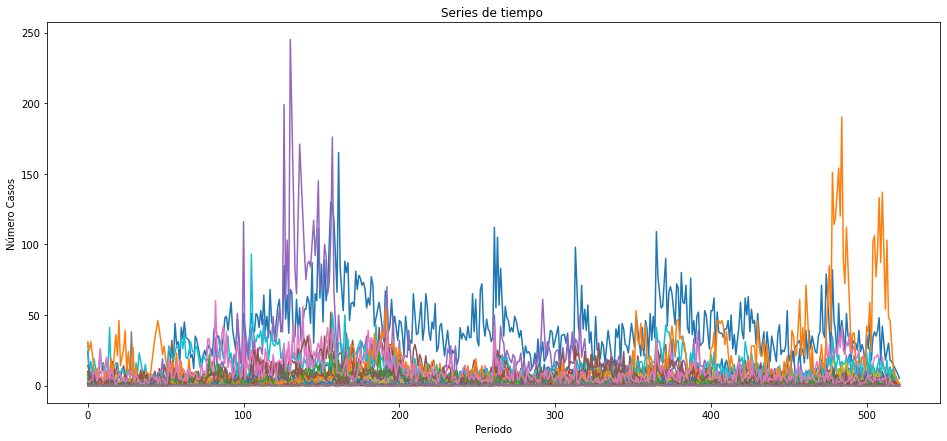

In [7]:
dept_list=df["departamento"].drop_duplicates().values

reframed_final=pd.DataFrame()
reframed_final_test=pd.DataFrame()

test_dept_dicc={}
for dept in dept_list:
    df_final=pd.DataFrame(df.query('departamento == @dept'))
    dff=pd.DataFrame()
    dff_full=pd.DataFrame()
    dff["periodo"]=df_final["periodo"]
    dff["casos_"]=df_final["casos_"]
    dff_full=dff
    
    plt.title('Series de tiempo ')
    plt.xlabel("Periodo")
    plt.ylabel("Número Casos")
    plt.plot(dff["casos_"].values)
    
    
    PASOS=6
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    # load dataset
    values = dff["casos_"].values
    # ensure all data is float
    values = values.astype('float32')

    # frame as supervised learning
    values=values.reshape(-1, 1)
    reframed = series_to_supervised(values, PASOS, 1)

    # split into train and test sets
    values = reframed

    #n_train_days = 522 - (180+PASOS)
    #316 mas test 418 menos test
    n_train_days = 316
    #n_train_days = 418
    
    train = values.iloc[:n_train_days, :]
    test = values.iloc[n_train_days:, :]
    
    reframed_final = pd.concat([reframed_final, train])     
    reframed_final.index = range(reframed_final.shape[0])
    test_dept_dicc[dept]=test
    reframed_final_test = pd.concat([reframed_final_test, test])
    reframed_final_test.index = range(reframed_final_test.shape[0])
    
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
#values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(reframed_final.values)

scaled_test=scaler.transform(reframed_final_test.values)   
    
for dept in dept_list:
    test_dept_dicc[dept]=pd.DataFrame(scaler.transform(test_dept_dicc[dept].values))
    
# split into input and outputs
x_train, y_train = scaled[:, :-1], scaled[:, -1]
x_val, y_val = scaled_test[:, :-1], scaled_test[:, -1]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

#Lo nuevo con validación 60, 20, 20
x_val2, x_test=np.split(x_val, 2)
print(x_val2.shape, x_test.shape)

y_val2, y_test=np.split(y_val, 2)
print(y_val2.shape, y_test.shape)

# TUNING KERAS - RandomizedSearchCV

#### Numero de capas y activacion

In [9]:
def tune_layers_model(hp):
    model = keras.Sequential()
    
    activation = hp.Choice('activation',
                        [
                          'softmax',
                          'softplus',
                          'softsign',
                          'relu',
                          'tanh',
                          'sigmoid',
                          'hard_sigmoid',
                          'linear'
                        ])
    batch_size= hp.Choice('batch_size',[2,4,8,16,32,64,128,256,512,1024])
    model.add(keras.layers.Dense(units=6,
                                 activation=activation,
                                 input_shape=[x_train.shape[2]]))
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=1,
                                            max_value=10,
                                            step=1),
                               activation=activation))
    model.add(keras.layers.Dense(1, activation='tanh'))
    
    #optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])
    
    model.compile(
        optimizer=keras.optimizers.SGD(lr=lr, momentum=momentum),
        loss = 'mse',
        metrics = ['mse'])
    return model

In [10]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5
tuner8 = RandomSearch(
    tune_layers_model,
    objective='mse',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir',
    project_name='tune_optimizer_8',
    seed=7
)

INFO:tensorflow:Reloading Oracle from existing project test_dir\tune_optimizer_8\oracle.json


In [11]:
nsamples, nx, ny = x_train.shape
x_train_new = x_train.reshape((nsamples,nx*ny))

nsamples_x_val, nx_val, ny_val = x_val.shape
x_val_new = x_val.reshape((nsamples_x_val,nx_val*ny_val))

print("x_train_new.shape ", x_train_new.shape)
print("x_val_new.shape ", x_val_new.shape)

print("y_train_.shape ", y_train.shape)
print("y_val.shape ", y_val.shape)


TRAIN_EPOCHS = 20
tuner8.search(x=x_train_new,
             y=y_train,
             epochs=TRAIN_EPOCHS,
             workers=8,
             validation_data=(x_val_new, y_val))

x_train_new.shape  (9408, 6)
x_val_new.shape  (5040, 6)
y_train_.shape  (9408,)
y_val.shape  (5040,)
Train on 9408 samples, validate on 5040 samples
Epoch 1/20
7008/9408 [=====================>........] - ETA: 1:37 - loss: 0.4306 - mse: 0.430 - ETA: 0s - loss: 0.3990 - mse: 0.3990  - ETA: 0s - loss: 0.3787 - mse: 0.3787

NotFoundError: Failed to create a NewWriteableFile: test_dir\tune_optimizer_8\trial_652debf3f532ce2ac400126dc052b6e5\checkpoints\epoch_0\checkpoint_temp_97234ec4bfa84ccbb97be670addfacad/part-00000-of-00001.data-00000-of-00001.tempstate1158361005509767029 : The system cannot find the path specified.
; No such process [Op:SaveV2]

In [11]:
tuner6.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'activation': 'softplus',
 'batch_size': 8,
 'num_layers': 2,
 'units_0': 2,
 'learning_rate': 0.1,
 'momentum': 0.4,
 'units_1': 5,
 'units_2': 5,
 'units_3': 3,
 'units_4': 3,
 'units_5': 5}

In [12]:
best_model6 = tuner6.get_best_models()[0]

In [13]:
best_model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


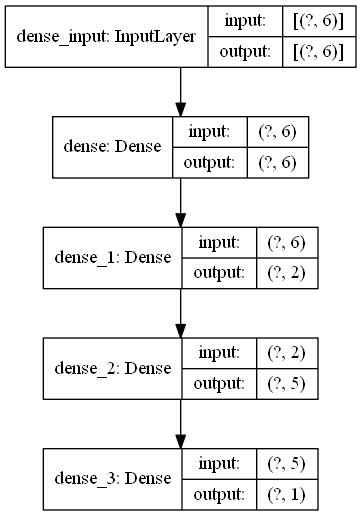

In [14]:
tf.keras.utils.plot_model(best_model6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Usar el modelo keras

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 6)              42        
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2)              14        
_________________________________________________________________
dense_2 (Dense)              (None, 1, 5)              15        
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              6         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              2         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


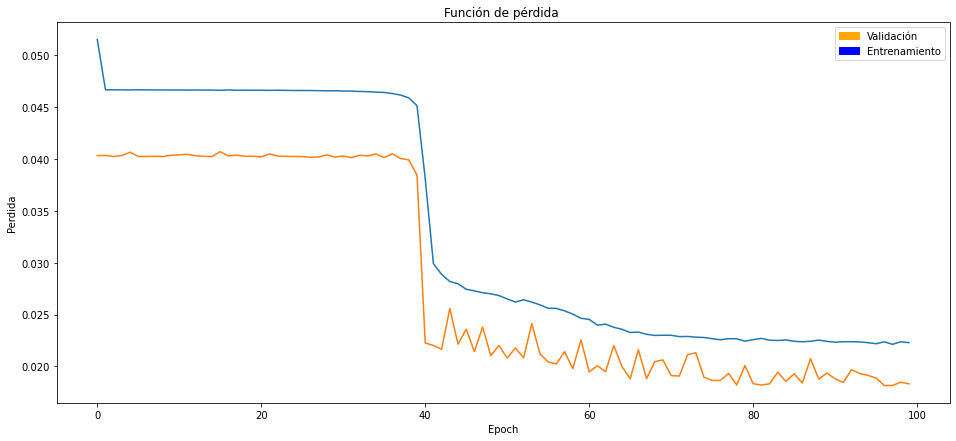

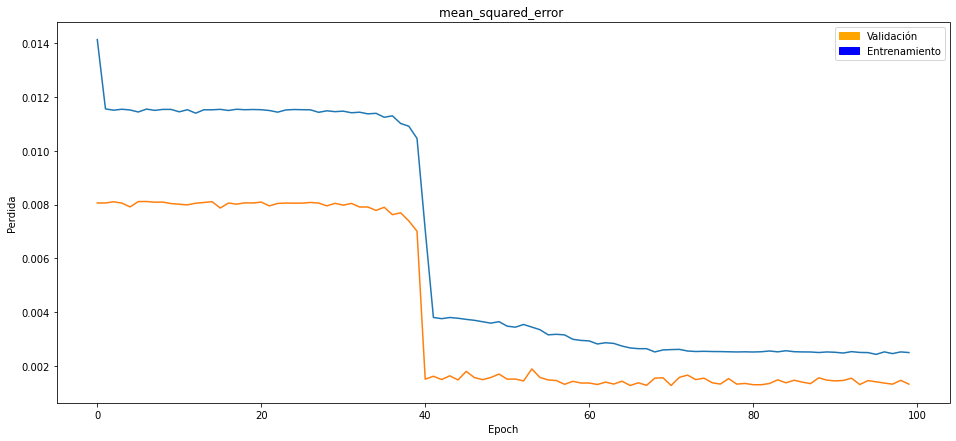

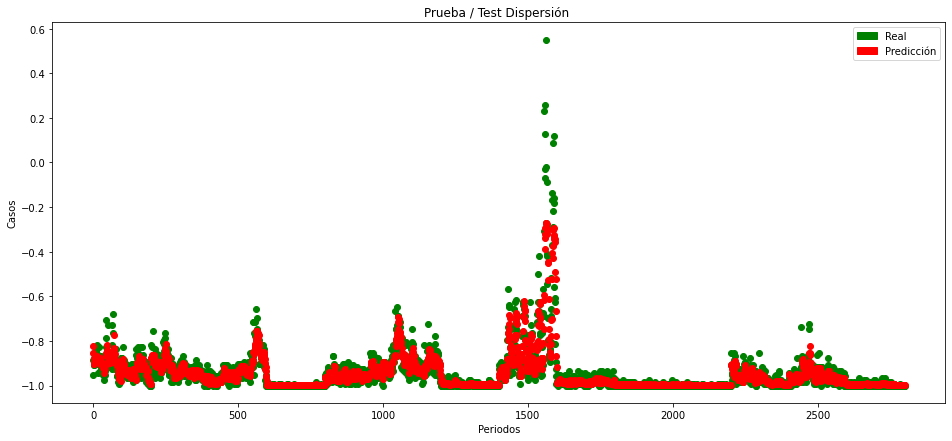

C:\Users\danny\.conda\envs\env_asus_old\lib\site-packages\ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


antes =  (2800, 2)
despues =  (2800, 7)
inverted =  (2800, 7)


real  prediccion  diferencia
0      5.999999   21.654206  -15.654207
1     14.000000   17.701990   -3.701991
2     11.000004   15.202911   -4.202907
3     12.999999   13.598662   -0.598663
4     11.000004   11.547359   -0.547355
...         ...         ...         ...
2795   0.000000    0.386925   -0.386925
2796   0.000000    0.386925   -0.386925
2797   0.000000    0.386925   -0.386925
2798   0.000000    0.386925   -0.386925
2799   0.000000    0.386925   -0.386925

[2800 rows x 3 columns]

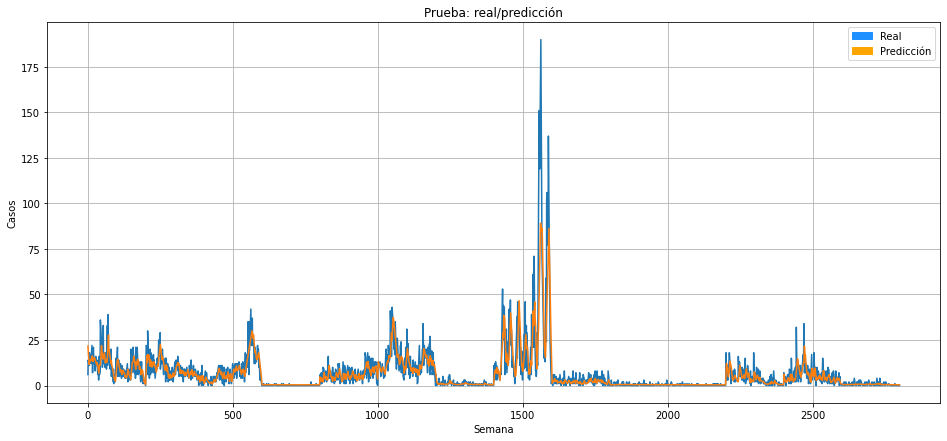

mean_absolute_error =  2.97027001447748
mean_squared_error =  42.72276955682872
r2_score =  0.7252350472596978
explained_variance_score =  0.7262329965675879


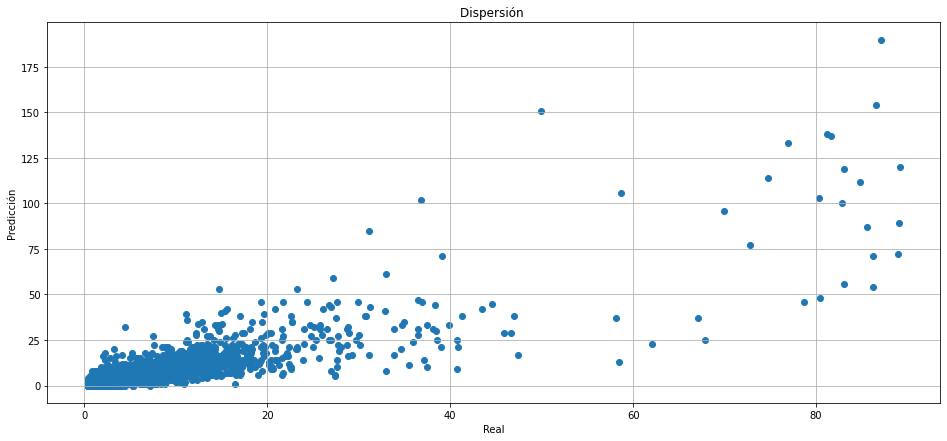

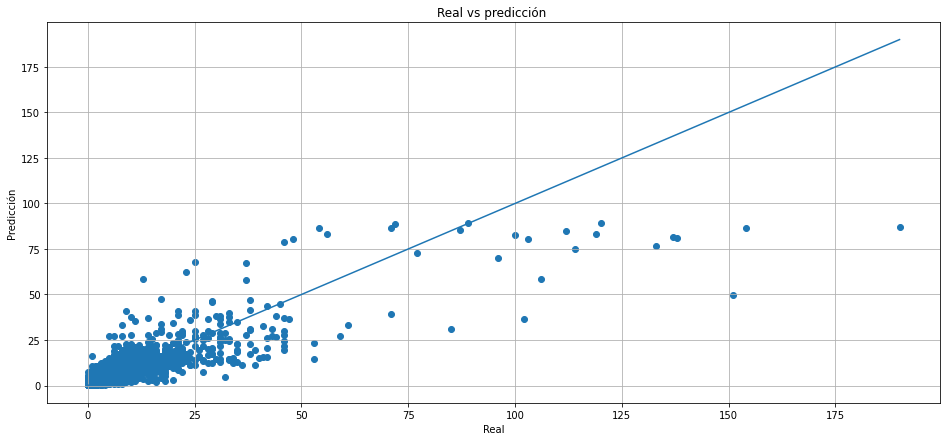

In [8]:
def crear_modeloFF():
    np.random.seed(7) # for reproducibility
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='softplus'))
    model.add(Dense(2, input_shape=(1, PASOS),activation='softplus'))
    model.add(Dense(5, input_shape=(1,2),activation='softplus'))
    model.add(Dense(1, input_shape=(1,5),activation='softplus'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',
                  optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.4), metrics=['mse'])
    model.summary()
    return model

EPOCHS=100
model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val2,y_val2), batch_size=8,
                  workers=12,verbose=0)


plt.figure()
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida ')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.figure()
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('mean_squared_error ')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.show()

#4 LINEAS SIGUIENTES PARA HACER METRICAS POR DEPARTAMENTO
# for dept in dept_list:
#     dept_df=test_dept_dicc[dept]
    
#     x_val, y_val = dept_df.values[:, :-1], dept_df.values[:, -1]
#     x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

#Metricas de todo
results=model.predict(x_test)
plt.figure()
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba / Test Dispersión ')
plt.xlabel("Periodos")
plt.ylabel("Casos")
plt.scatter(range(len(y_test)),y_test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.show()

compara = pd.DataFrame(np.array([y_test, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']
print("antes = ",compara.shape)
compara=pd.concat([compara, compara, compara, compara["real"]], axis=1)    
print("despues = ", compara.shape)
inverted = scaler.inverse_transform(compara.values)
print("inverted = ", inverted.shape)
compara2 = pd.DataFrame(inverted[:,:2])
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
display(compara2.tail(4000))

compara2.describe()

#plt.figure()
#green_patch = mpatches.Patch(color='green', label='Real')
#red_patch = mpatches.Patch(color='red', label='Predicción')
#plt.legend(handles=[green_patch, red_patch])
#plt.title('Prueba / Test ')
#plt.xlabel("Periodos")
#plt.ylabel("Casos")
#compara2['real'].plot()
#compara2['prediccion'].plot()
#plt.show()


plt.title('Prueba: real/predicción')
plt.xlabel("Semana")
plt.ylabel("Casos")
compara2['real'].plot()
compara2['prediccion'].plot()
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label='Real')
red_patch = mpatches.Patch(color='orange', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.show()


print("mean_absolute_error = ",mean_absolute_error(compara2["real"], compara2["prediccion"]))
print("mean_squared_error = ",mean_squared_error(compara2["real"], compara2["prediccion"]))
print("r2_score = ", r2_score(compara2["real"], compara2["prediccion"]))
print("explained_variance_score = ",explained_variance_score(compara2["real"], compara2["prediccion"]))

plt.figure()
plt.title('Dispersión ')
plt.xlabel("Real")
plt.ylabel("Predicción")
x = compara2["real"].values
y = compara2["prediccion"].values
plt.scatter(y, x)
plt.grid(True)
plt.show()

plt.figure()
identity_line = np.linspace(x.min(), x.max())
plt.scatter(x, y)
plt.title('Real vs predicción ')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.plot(identity_line, identity_line)
plt.grid(True)
plt.show()



# TUNING XGBOOST - RandomizedSearchCV

In [8]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor()

In [9]:
parameters = {"learning_rate"    : [0.001, 0.01, 0.03,0.04,0.05, 0.06,0.10, 0.20, 0.50, 0.90 ] ,
              "base_score":[0.1,0.3,0.4,0.5,0.6,0.8,0.9,0.99,0.999],

 "max_depth"        : [6, 7, 8, 9, 10, 12, 15],
 "min_child_weight" : [1, 3, 5, 7 ],
 'gamma':[0.01,0.04,0.05,0.06,0.07,0.08,0.09, 0.1,0.5,0.9],
 'subsample':[0.5,0.6,0.8,0.9,0.99,0.999],
 'colsample_bytree':[0.1,0.3,0.4,0.5,0.6,0.8,0.9,0.99,0.99],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05,0.06, 0.07, 0.08,0.09,0.1],
             'n_estimators':[100, 500, 1000]}

In [10]:
clf = RandomizedSearchCV(xg_reg, parameters, n_jobs=12, n_iter=100,verbose=2, refit=True, random_state=7)

In [11]:
nsamples, nx, ny = x_train.shape
x_train_new = x_train.reshape((nsamples,nx*ny))

clf.fit(x_train_new, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  6.3min finished


[12:13:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(estimator=XGBRegressor(), n_iter=100, n_jobs=12,
                   param_distributions={'base_score': [0.1, 0.3, 0.4, 0.5, 0.6,
                                                       0.8, 0.9, 0.99, 0.999],
                                        'colsample_bytree': [0.1, 0.3, 0.4, 0.5,
                                                             0.6, 0.8, 0.9,
                                                             0.99, 0.99],
                                        'gamma': [0.01, 0.04, 0.05, 0.06, 0.07,
                                                  0.08, 0.09, 0.1, 0.5, 0.9],
                                        'learning_rate': [0.001, 0.01, 0.03,
                                                          0.04, 0.05, 0.06, 0.1,
                                                          0.2, 0.5, 0.9],
                                        'max_depth': [6, 7, 8, 9, 10, 12, 15],
                                        'min_child_weight': [1, 3, 5, 7],

In [12]:
nsamples_x_val, nx_val, ny_val = x_val.shape
x_val_new = x_val.reshape((nsamples_x_val,nx_val*ny_val))

print(x_val_new.shape)
print(y_val.shape)

results2=clf.predict(x_val_new)

(2744, 6)
(2744,)


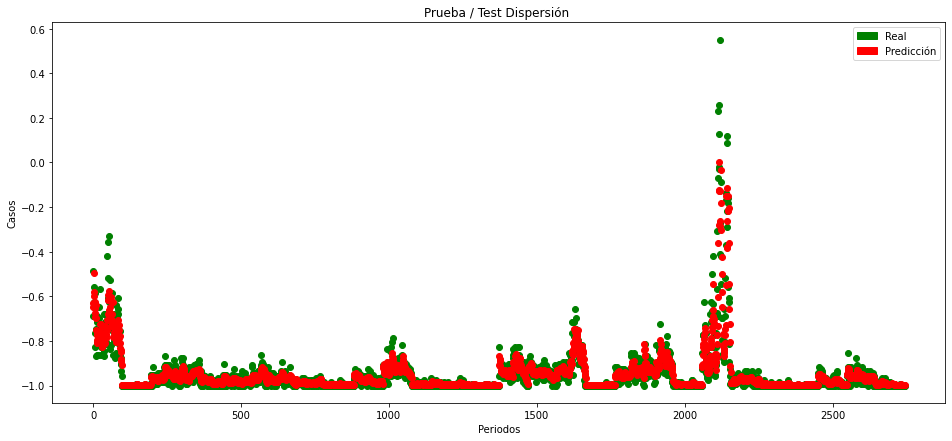

(2744, 2)


real  prediccion  diferencia
0     63.000000   45.507462   17.492538
1     37.999996   43.348591   -5.348595
2     53.999996   49.063530    4.936466
3     44.000000   61.846489  -17.846489
4     46.000004   51.576862   -5.576859
...         ...         ...         ...
2739   0.000000    0.440891   -0.440891
2740   0.000000    0.440891   -0.440891
2741   0.000000    0.440891   -0.440891
2742   0.000000    0.440891   -0.440891
2743   0.000000    0.440891   -0.440891

[2744 rows x 3 columns]

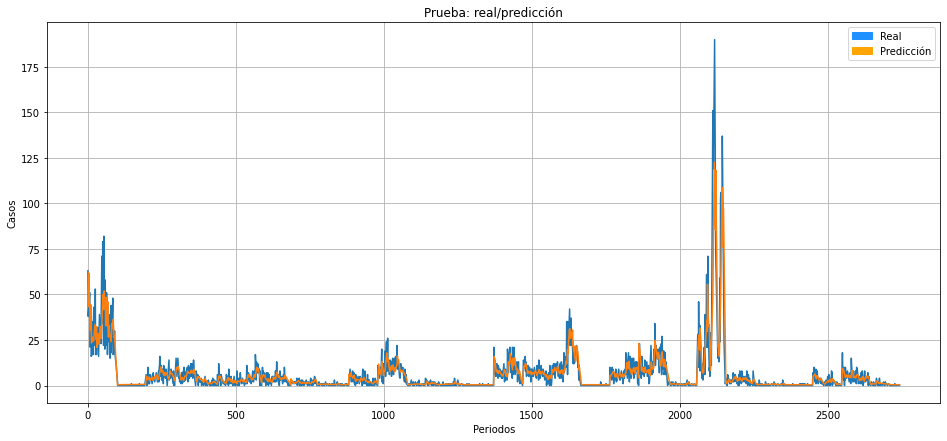

mean_absolute_error =  2.682636
mean_squared_error =  39.601704
r2_score =  0.7648497755287
explained_variance_score =  0.76495361328125


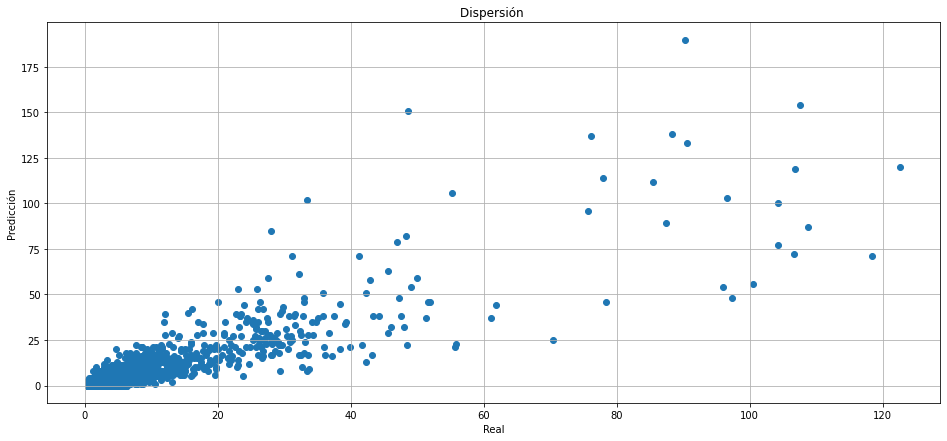

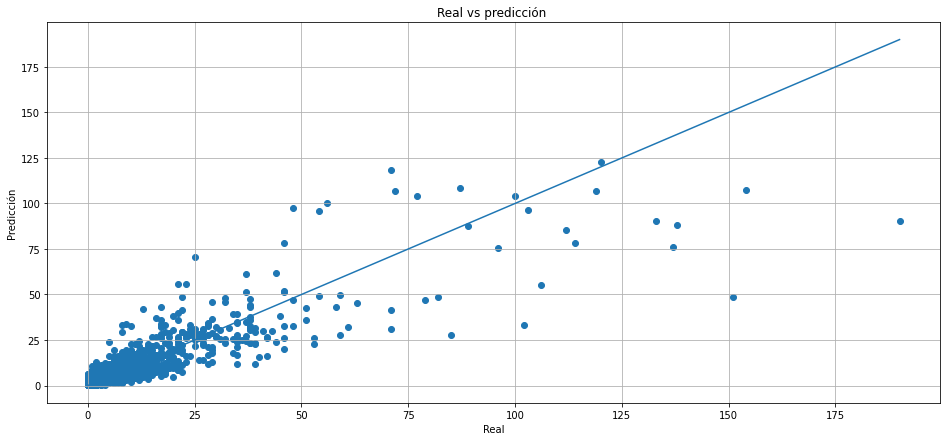

In [13]:

from matplotlib import pyplot

plt.figure()
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba / Test Dispersión ')
plt.xlabel("Periodos")
plt.ylabel("Casos")
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results2)),results2,c='r')
plt.show()

compara = pd.DataFrame(np.array([y_val, [x for x in results2]])).transpose()
compara.columns = ['real', 'prediccion']
print(compara.shape)
compara=pd.concat([compara, compara, compara, compara["real"]], axis=1)     
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted[:,:2])
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
display(compara2.tail(4000))

compara2.describe()

plt.title('Prueba: real/predicción')
plt.xlabel("Periodos")
plt.ylabel("Casos")
compara2['real'].plot()
compara2['prediccion'].plot()
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label='Real')
red_patch = mpatches.Patch(color='orange', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.show()

print("mean_absolute_error = ",mean_absolute_error(compara2["real"], compara2["prediccion"]))
print("mean_squared_error = ",mean_squared_error(compara2["real"], compara2["prediccion"]))
print("r2_score = ", r2_score(compara2["real"], compara2["prediccion"]))
print("explained_variance_score = ",explained_variance_score(compara2["real"], compara2["prediccion"]))

plt.figure()
plt.title('Dispersión ')
plt.xlabel("Real")
plt.ylabel("Predicción")
x = compara2["real"].values
y = compara2["prediccion"].values
plt.scatter(y, x)
plt.grid(True)
plt.show()

plt.figure()
identity_line = np.linspace(x.min(), x.max())
plt.scatter(x, y)
plt.title('Real vs predicción ')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.plot(identity_line, identity_line)
plt.grid(True)
plt.show()

In [12]:
params=clf.best_estimator_.get_params()

In [13]:
params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0.3,
 'importance_type': 'gain',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0.05,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 1}

In [30]:
d2_train_dataset.shape

(8848, 6)

In [31]:
x_val_new.shape

(2800, 6)

### Usar el modelo XGBOOST

(8848, 6)
(8848,)
(2800, 6)
(2800, 6)
(2800,)
(2800, 1, 6)


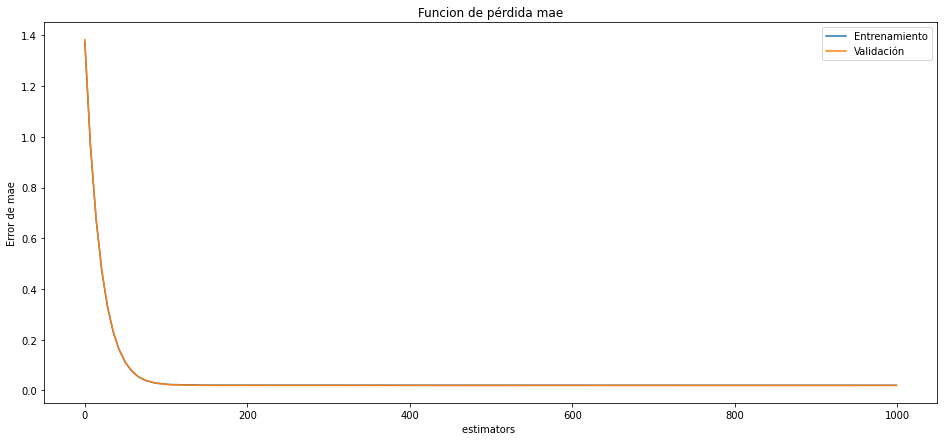

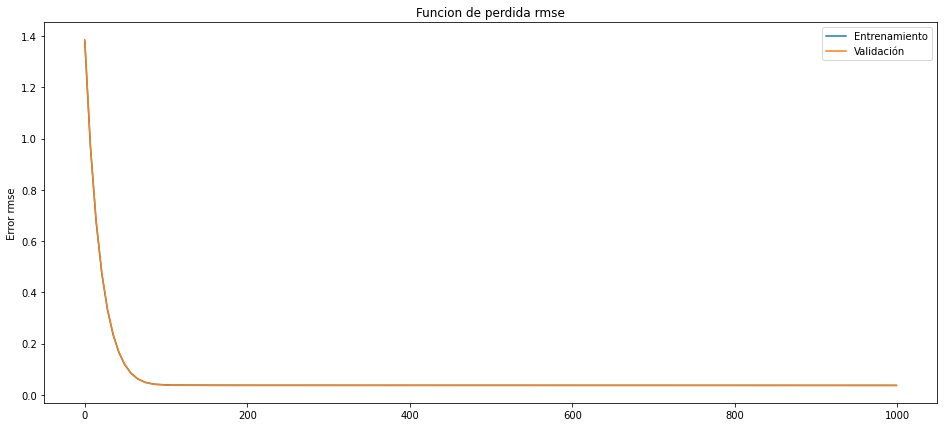

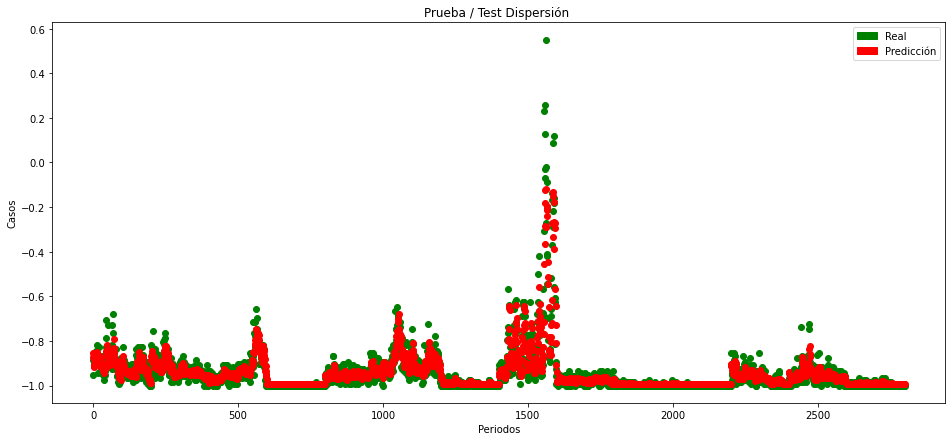

(2800, 2)


real  prediccion  diferencia
0      5.999999   17.997623  -11.997624
1     14.000000   15.415774   -1.415774
2     11.000004   14.186321   -3.186317
3     12.999999   11.403196    1.596803
4     11.000004   10.872109    0.127894
...         ...         ...         ...
2795   0.000000    0.731486   -0.731486
2796   0.000000    0.731486   -0.731486
2797   0.000000    0.731486   -0.731486
2798   0.000000    0.731486   -0.731486
2799   0.000000    0.731486   -0.731486

[2800 rows x 3 columns]

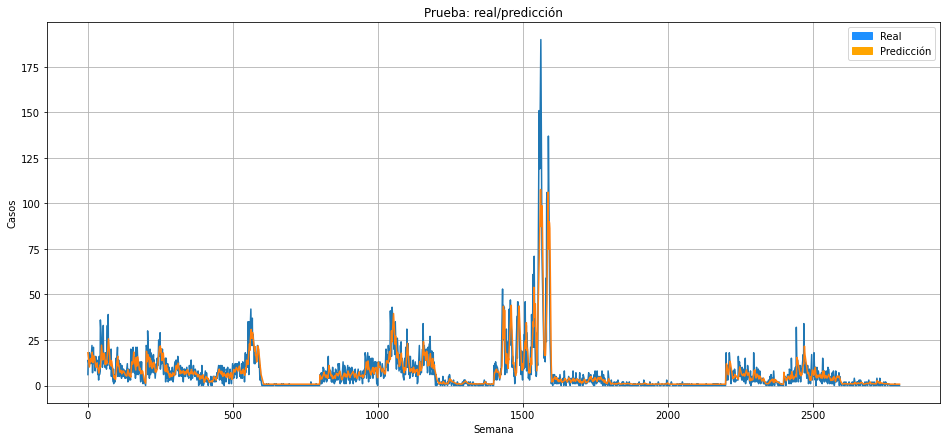

mean_absolute_error =  2.9886055
mean_squared_error =  39.19995
r2_score =  0.7478915166394821
explained_variance_score =  0.7478917241096497


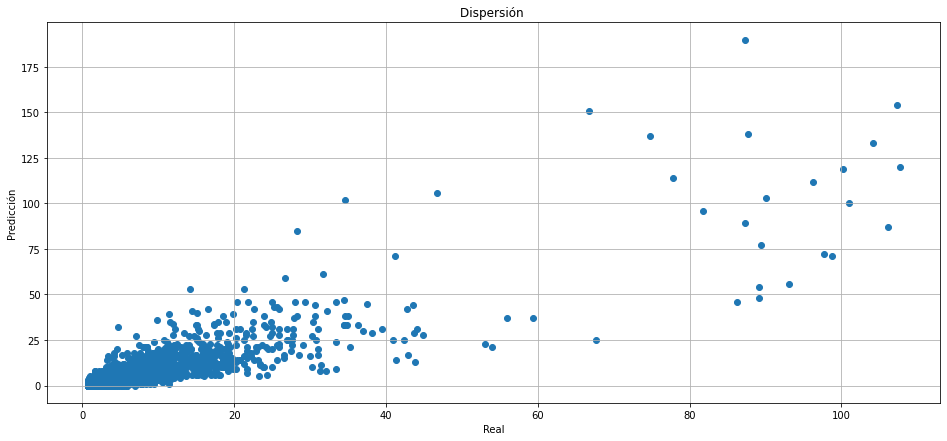

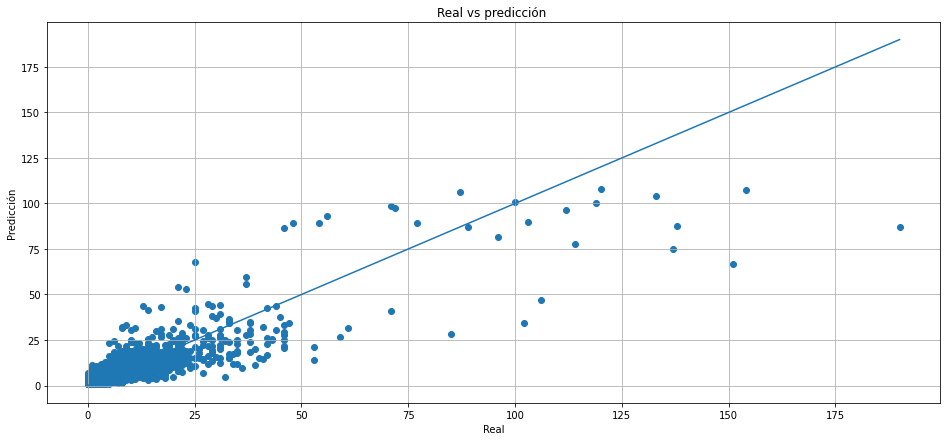

In [11]:
nsamples, nx, ny = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny))


nsamples_x_val, nx_val, ny_val = x_val2.shape
x_val_new = x_val2.reshape((nsamples_x_val,nx_val*ny_val))

nsamples_x_test, nx_test, ny_test = x_test.shape
x_test_new = x_test.reshape((nsamples_x_test,nx_test*ny_test))

print(d2_train_dataset.shape)
print(y_train.shape)
print(x_val_new.shape)

print(x_test_new.shape)
print(y_test.shape)
print(x_test.shape)

eval_set = [(d2_train_dataset, y_train),(x_val_new, y_val2)]

from xgboost import XGBRegressor
xg_reg = XGBRegressor(base_score=0.5,
 booster= 'gbtree',
 colsample_bylevel= 1,
 colsample_bynode= 1,
 colsample_bytree= 0.9,
 gamma= 0.09,
 importance_type= 'gain',
 learning_rate= 0.05,
 max_delta_step= 0,
  max_depth= 9,
 min_child_weight= 1,
 n_estimators= 1000,
 n_jobs= 11,
 objective= 'reg:squarederror',
 random_state= 7,
 reg_alpha= 0.07,
 reg_lambda= 1,
 scale_pos_weight= 1,
 subsample= 0.999,
 verbosity= 1)
xg_reg.fit(d2_train_dataset, y_train, eval_metric=["mae", "rmse"], eval_set=eval_set, verbose=False)

results2=xg_reg.predict(x_test_new)

from matplotlib import pyplot

results = xg_reg.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Entrenamiento')
ax.plot(x_axis, results['validation_1']['mae'], label='Validación')
ax.legend()
pyplot.ylabel('Error de mae')
pyplot.xlabel('estimators ')
pyplot.title('Funcion de pérdida mae')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Entrenamiento')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validación')
ax.legend()
pyplot.ylabel(' Error rmse ')
pyplot.title('Funcion de perdida rmse')
pyplot.show()

plt.figure()
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba / Test Dispersión ')
plt.xlabel("Periodos")
plt.ylabel("Casos")
plt.scatter(range(len(y_test)),y_test,c='g')
plt.scatter(range(len(results2)),results2,c='r')
plt.show()

compara = pd.DataFrame(np.array([y_test, [x for x in results2]])).transpose()
compara.columns = ['real', 'prediccion']
print(compara.shape)
compara=pd.concat([compara, compara, compara, compara["real"]], axis=1)     
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted[:,:2])
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
display(compara2.tail(4000))

compara2.describe()

#plt.figure()
#green_patch = mpatches.Patch(color='blue', label='Real')
#red_patch = mpatches.Patch(color='orange', label='Predicción')
#plt.legend(handles=[green_patch, red_patch])
#plt.title('Prueba / Test ')
#plt.xlabel("Periodos")
#plt.ylabel("Casos")
#compara2['real'].plot()
#compara2['prediccion'].plot()
#plt.show()

plt.title('Prueba: real/predicción')
plt.xlabel("Semana")
plt.ylabel("Casos")
compara2['real'].plot()
compara2['prediccion'].plot()
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label='Real')
red_patch = mpatches.Patch(color='orange', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.show()

print("mean_absolute_error = ",mean_absolute_error(compara2["real"], compara2["prediccion"]))
print("mean_squared_error = ",mean_squared_error(compara2["real"], compara2["prediccion"]))
print("r2_score = ", r2_score(compara2["real"], compara2["prediccion"]))
print("explained_variance_score = ",explained_variance_score(compara2["real"], compara2["prediccion"]))

plt.figure()
plt.title('Dispersión ')
plt.xlabel("Real")
plt.ylabel("Predicción")
x = compara2["real"].values
y = compara2["prediccion"].values
plt.scatter(y, x)
plt.grid(True)
plt.show()

plt.figure()
identity_line = np.linspace(x.min(), x.max())
plt.scatter(x, y)
plt.title('Real vs predicción ')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.plot(identity_line, identity_line)
plt.grid(True)
plt.show()

In [27]:
results['validation_1']

{'mae': [1.383672,
  1.314663,
  1.249127,
  1.18686,
  1.127635,
  1.071419,
  1.017977,
  0.967229,
  0.918984,
  0.873171,
  0.82971,
  0.788375,
  0.74913,
  0.71178,
  0.676331,
  0.642671,
  0.610692,
  0.580317,
  0.551441,
  0.524016,
  0.497959,
  0.47323,
  0.4497,
  0.427338,
  0.406082,
  0.385917,
  0.366783,
  0.348642,
  0.331368,
  0.314981,
  0.299382,
  0.284579,
  0.270553,
  0.257193,
  0.244551,
  0.232549,
  0.221129,
  0.210319,
  0.200033,
  0.190262,
  0.180993,
  0.172218,
  0.163898,
  0.156009,
  0.14852,
  0.141428,
  0.134692,
  0.128293,
  0.122244,
  0.116487],
 'rmse': [1.386133,
  1.317067,
  1.251473,
  1.189152,
  1.129879,
  1.073627,
  1.020151,
  0.969369,
  0.921107,
  0.875278,
  0.831798,
  0.790451,
  0.751195,
  0.713839,
  0.67839,
  0.644711,
  0.612721,
  0.582343,
  0.55347,
  0.52605,
  0.500001,
  0.475285,
  0.451778,
  0.429447,
  0.408232,
  0.388105,
  0.368989,
  0.350869,
  0.333618,
  0.317253,
  0.301687,
  0.286919,
  0.272942,

In [29]:
results['validation_0']

{'mae': [1.376123,
  1.307376,
  1.242079,
  1.180038,
  1.121095,
  1.065097,
  1.011899,
  0.961365,
  0.913343,
  0.867725,
  0.824397,
  0.783234,
  0.74413,
  0.706995,
  0.671707,
  0.638189,
  0.606349,
  0.576108,
  0.547371,
  0.520065,
  0.494135,
  0.469495,
  0.446094,
  0.423856,
  0.40273,
  0.382658,
  0.363587,
  0.345487,
  0.328303,
  0.311994,
  0.296489,
  0.281768,
  0.267792,
  0.254523,
  0.241928,
  0.229954,
  0.218581,
  0.207786,
  0.197557,
  0.187841,
  0.178628,
  0.169887,
  0.161588,
  0.153737,
  0.146301,
  0.139255,
  0.132567,
  0.126219,
  0.120218,
  0.114499],
 'rmse': [1.379446,
  1.310612,
  1.245216,
  1.18309,
  1.12407,
  1.068005,
  1.014746,
  0.964151,
  0.916083,
  0.870423,
  0.827049,
  0.785847,
  0.746712,
  0.709537,
  0.674224,
  0.640669,
  0.608796,
  0.578531,
  0.549773,
  0.522461,
  0.496528,
  0.471884,
  0.448485,
  0.426263,
  0.405165,
  0.385123,
  0.366084,
  0.34801,
  0.330864,
  0.314583,
  0.299111,
  0.284415,
  0.2

In [37]:
d2_train_dataset

array([[-0.98367345, -1.        , -1.        , -1.        , -0.98367345,
        -1.        ],
       [-1.        , -1.        , -1.        , -0.98367345, -1.        ,
        -1.        ],
       [-1.        , -1.        , -0.98367345, -1.        , -1.        ,
        -1.        ],
       ...,
       [-0.9755102 , -1.        , -1.        , -0.9918367 , -0.9755102 ,
        -0.9918367 ],
       [-1.        , -1.        , -0.9918367 , -0.9755102 , -0.9918367 ,
        -0.9918367 ],
       [-1.        , -0.9918367 , -0.9755102 , -0.9918367 , -0.9918367 ,
        -1.        ]], dtype=float32)

In [ ]:
x_val_new[0]

In [52]:
all(np.in1d(x_val_new, x_val_new[1]))

False

In [59]:
def iguales(x, y):
    return np.allclose(x,y)

In [60]:
for j in x_val_new:
    for i in d2_train_dataset:
        print("i =",i)
        print("j =",j)
        if(iguales(j, i)):
            print(i)

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.][-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. 

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.

[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1.         -0.9755102  -0.98367345 -1.         -0.9918367  -1.        ]
[-0.9755102  -0.98367345 -0.9755102  -0.98367345 -0.96734697 -0.9755102 ]
[-0.98367345 -0.9755102  -0.98367345 -0.96734697 -0.9755102  -0.98367345]
[-0.9755102  -1.         -0.98367345 -0.98367345 -1.         -0.98367345]
[-1.         -0.98367345 -0.98367345 -1.         -0.98367345 -0.9918367 ]
[-0.98367345 -1.         -0.98367345 -0.9918367  -0.98367345 -0.9755102 ]
[-0.9918367  -0.98367345 -0.9755102  -0.96734697 -0.98367345 -

[-0.9918367  -0.9918367  -0.9918367  -0.98367345 -1.         -1.        ]
[-0.9918367  -0.9918367  -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -0.9918367  -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -0.9918367  -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -0.98367345 -1.         -1.         -1.         -0.9918367 ]
[-0.9918367  -0.98367345 -1.         -1.         -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-1.        -1.        -1.        -0.9

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -1.         -0.9918367 ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.         -0.9918367  -1.         -0.98367345 -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.         -0.9918367  -1.         -1.         -0.98367345 -1.        ]
[-1.         -0.9918367  -1.         -1.         -0.98367345 -1.        ]
[-1.         -0.9918367  -1.         -1.         -0.98367345 -1.        ]
[-1.         -0.9918367  -1.         -1.         -0.98367345 -1.        ]
[-0.9918367  -1.         -1.         -0.98367345 -1.         -0.9918367 ]
[-0.9918367  -1.         -1.         -0.98367345 -1.         -0.9918367 ]
[-0.9918367  -1.         -1.         -0.98367345 -1.         -0.9918367 ]
[-0.9918367  -1.         -1.         -0.98367345 -1.         -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -0.9918367  -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -0.9918367  -0.9918367 ]
[-1.         -1.         -0.98367345 -1.         -0.9918367  -0.9918367 ]
[-1.         -0.98367345 -1.         -0.9918367  -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -0.9918367  -0.9918367  -1.        ]
[-1.         -0.98367345 -1.         -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.        -1.       ]
[-0.9918367 -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.

[-0.9918367 -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-0.9918367  -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.

[-0.9918367 -0.9918367 -1.        -1.        -1.        -0.9918367]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -0.9918367]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -0.9918367]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -0.9918367]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367  -1.         -1.         -0.9918367  -1.         -0.98367345]
[-0.9918367  -1.         -1.         -0.9918367  -1.         -0.98367345]
[-1.         -1.         -0.9918367 

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-1.         -1.         -0.98367345 -0.98367345 -0.9918367  -1.        ]
[-1.         -1.         -0.98367345 -0.98

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.

[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-0.98367345 -1.         -1.         -1.         -1.         -1.        ]
[-0.98367345 -1.         -1.         -1.         -1.         -1.        ]
[-0.98367345 -1.         -1.         -1.         -1.         -1.        ]
[-0.98367345 -1.         -1.         -1.         -1.         -1.        ]
[-0.98367345 -1.         -1.         -1.         -1.         -1.        ]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.

[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.

[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.  

[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -0.9918367]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.         -0.98367345 -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -0.9918367  -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -0.9918367  -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -0.9918367  -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -0.9918367  -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -0.9918367  -1.         -0.9918367 ]
[-1.         -1.         -0.9918367  -1.         -0.9918367  -0.98367345]
[-1.         -1.         -0.9918367  -1.         -0.9918367  -0.98367345]
[-1.         -1.         -0.9918367  -1.         -0.9918367  -0.98367345]
[-1.         -1.         -0.9918367  -1.         -0.9918367  -0.98367345]
[-1.         -0.9918367  -1.         -0.9918367  -0.98367345 -0.9918367 ]
[-0.9918367  -0.98367345 -0.9918367  -0.9755102  -0.9918367  -0.98367345]
[-0.9755102  -0.9918367  -0.98367345 -1.         -0.9918367  -1.        ]
[-0.9918367  -0.98367345 -1.         -

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.         -0.98367345 -1.         -1.         -1.         -0.9918367 ]
[-1.         -0.98367345 -1.         -1.         -1.         -0.9918367 ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-0.98367345 -1.         -1.         -1.         -0.9918367  -1.        ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.   

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -1.         -0.98367345 -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-1.         -0.98367345 -1.         -1.         -1.         -1.        ]
[-0.98367345 -1.         -1.         -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.     

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.

[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367  -1.         -1.         -1.         -1.         -0.98367345]
[-0.9918367  -1.         -1.         -1.         -1.         -0.98367345]
[-0.9918367  -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -0.98367345 -1.        ]
[-1.         -1.         -1.         -1.         -0.98367345 -1.        ]
[-1.         -1.  

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-0.9918367 -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -0.9918367 -1.        -1.       ]
[-1.        -1.        -0.9918367 -0.9918367 -1.

[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.9918367 -1.       ]
[-1.        -1.        -0.9918367 -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -1.        -0.9918367 -1.        -1.        -0.9918367]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-1.        -0.9918367 -1.        -1.        -0.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -0.9918367 -0.9918367 -1.        -1.        -0.9918367]
[-1.        -0.9918367 -0.9918367 -1.        -1.        -0.9918367]
[-1.        -0.9918367 -0.9918367 -1.        -1.        -0.9918367]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.9918367 -1.       ]
[-0.9918367 -0.9918367 -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.        -0.9918367]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -1.         -0.98367345]
[-1.         -1.         -1.         -1.         -0.98367345 -1.        ]
[-1.         -1.         -1.         -1.         -0.98367345 -1.        ]
[-1.         -1.         -1.         -

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.        -0.9918367]
[-1.        -1.        -1.        -1.        -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.9918367 -1.       ]
[-1.        -1.        -1.        -1.        -0.

[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.        -1.       ]
[-1.        -1.        -1.        -0.9918367 -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.        -1.       ]
[-1.        -1.        -0.9918367 -1.        -1.

[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.        -1.       ]
[-1.        -0.9918367 -1.        -1.        -1.

[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.        -1.       ]
[-0.9918367 -1.        -1.        -1.        -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1.]
[-1. -1. -1.

## Draw xgbost model

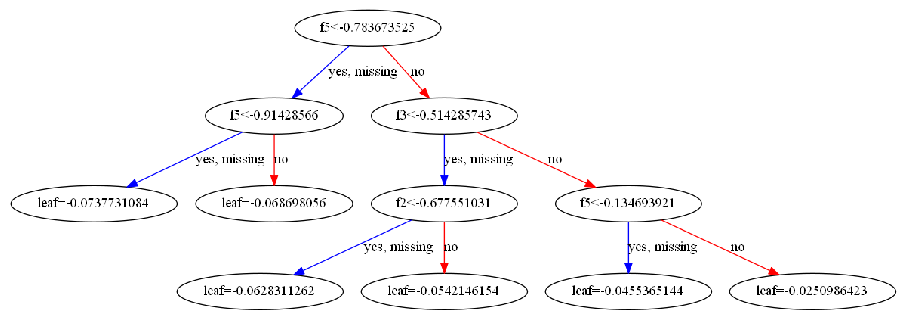

In [9]:
from xgboost import plot_tree
plot_tree(xg_reg)
plt.show()

# Draw NN

In [8]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

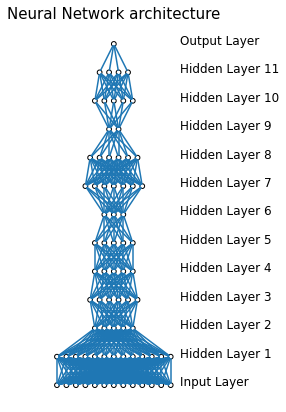

In [9]:
network = DrawNN( [13,13,5,6,5,5,3,7,6,2,5,4,1] )
network.draw()

In [20]:
rms_k = RandomizedSearchCV(model2, param_distributions=params_k, cv=3, n_iter=10)
nsamples, nx, ny = x_train.shape
x_train_new = x_train.reshape((nsamples,nx*ny))
rms_k.fit(x_train_new, y_train)

TypeError: can't pickle _thread._local objects

In [12]:
mlp = MLPRegressor()
nsamples, nx, ny = x_train.shape
x_train_new = x_train.reshape((nsamples,nx*ny))
rms = RandomizedSearchCV(mlp, params, random_state=7, n_iter=100, verbose=7, cv=5, n_jobs=6)
best_model=rms.fit(x_train_new, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   13.4s
[Parallel(n_jobs=6)]: Done 351 tasks      | elapsed:   26.3s
[Parallel(n_jobs=6)]: Done 455 tasks      | elapsed:   32.3s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:   39.0s finished


In [22]:
print('Best activation:', best_model.best_estimator_.get_params()['activation'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best hidden_layer_sizes:', best_model.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best batch_size:', best_model.best_estimator_.get_params()['batch_size'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])

Best activation: tanh
Best solver: lbfgs
Best learning_rate: adaptive
Best alpha: 1.4566564722753947
Best hidden_layer_sizes: (109, 57)
Best batch_size: 512
Best max_iter: 200


## GridSearchCV

In [201]:
from sklearn.model_selection import GridSearchCV
mlp = MLPRegressor()
nsamples, nx, ny = x_train.shape
x_train_new = x_train.reshape((nsamples,nx*ny))
gs = GridSearchCV(estimator=mlp, param_grid=params, n_jobs=6, cv=3, refit=True, verbose=5)  # <-- verbose=5
best_model_GS=gs.fit(x_train_new, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  90 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:    2.0s finished


In [202]:
print('Best activation:', best_model_GS.best_estimator_.get_params()['activation'])
print('Best solver:', best_model_GS.best_estimator_.get_params()['solver'])
print('Best learning_rate:', best_model_GS.best_estimator_.get_params()['learning_rate'])
print('Best alpha:', best_model_GS.best_estimator_.get_params()['alpha'])
print('Best hidden_layer_sizes:', best_model_GS.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best batch_size:', best_model_GS.best_estimator_.get_params()['batch_size'])
print('Best max_iter:', best_model_GS.best_estimator_.get_params()['max_iter'])

Best activation: tanh
Best solver: adam
Best learning_rate: constant
Best alpha: 0.0001
Best hidden_layer_sizes: (90, 30, 10)
Best batch_size: auto
Best max_iter: 200
